# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:59<00:00, 1470.41it/s]


In [23]:
# Combining all the above stundents 
from tqdm import tqdm
summary_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    summary_reviews.append(sentance.strip())

 37%|███████████████████████████▍                                              | 32585/87773 [00:15<00:22, 2400.52it/s]C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▋                      | 61272/87773 [00:30<00:13, 1909.40it/s]C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 75%|███████████████████████████████████████████████████████▎                  | 65573/87773 [00:32<00:11, 1891.55it/s]C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks 

In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [27]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [26]:
len(summary_reviews)

87773

In [27]:
length_of_summary=[]
for i in range(len(summary_reviews)):
    length_of_summary.append(len(summary_reviews[i]))

In [28]:
print(length_of_summary[:5])

[10, 17, 18, 24, 7]


In [29]:
final['length_of_Summary']=length_of_summary

In [30]:
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]=preprocessed_reviews[i]+' '+summary_reviews[i]

In [31]:
i=0

In [32]:
a=5
for i in range(a):
    print(preprocessed_reviews[i])
    print("***********************")

dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports made china
***********************
dogs love saw pet store tag attached regarding made china satisfied safe dog lover delites
***********************
infestation fruitflies literally everywhere flying around kitchen bought product hoping least get rid weeks fly stuck going around notepad squishing buggers success rate day clearly product useless even dabbed red wine banana top column week really attracted red wine glass still nothing get stuck actually saw second fly land watched flapped wings frantically within secs unstuck product total waste money one fruitfly stuck
***********************
worst product gotten long time would rate no star could simply not catch single fly bug sort went hardware store bought old fashioned spiral fly paper effective unuasual influx flys house fall needed something not work not waste money
**

In [33]:
final['clean_summary']=summary_reviews

In [34]:
final['clean_text']=preprocessed_reviews

In [35]:
final['clean_text'].head(5)

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
Name: clean_text, dtype: object

In [36]:
final=final.sort_values('Time',ascending=True)

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'],random_state = 0, test_size = 0.2,shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [249]:
%%time
# Please write all the code with proper documentation

#BoW
count_vect = CountVectorizer(ngram_range=(1,2),min_df=200,max_df=7000) #in scikit-learn
count_vect.fit(x_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_test))
print("the shape of out text BOW vectorizer ",final_counts_x_test.get_shape())
print("the number of unique words ", final_counts_x_test.get_shape()[1])

some feature names  ['able', 'able find', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according', 'acid', 'acidic', 'across']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 1755)
the number of unique words  1755
Wall time: 23.6 s


In [250]:
import scipy
from scipy.sparse import coo_matrix,hstack

In [251]:
length_of_summary=np.array(length_of_summary)

In [252]:
np.hstack((final_counts_x_train,length_of_summary[:52663]))

array([<52663x1755 sparse matrix of type '<class 'numpy.int64'>'
	with 1332896 stored elements in Compressed Sparse Row format>,
       10, 17, ..., 22, 5, 8], dtype=object)

In [253]:
np.hstack((final_counts_x_crossval,length_of_summary[52663:70218]))

array([<17555x1755 sparse matrix of type '<class 'numpy.int64'>'
	with 450710 stored elements in Compressed Sparse Row format>,
       25, 8, ..., 6, 9, 11], dtype=object)

In [254]:
np.hstack((final_counts_x_crossval,length_of_summary[70218:]))

array([<17555x1755 sparse matrix of type '<class 'numpy.int64'>'
	with 450710 stored elements in Compressed Sparse Row format>,
       3, 6, ..., 13, 42, 9], dtype=object)

In [255]:
from sklearn.preprocessing import normalize
final_counts_x_train=normalize(final_counts_x_train)
final_counts_x_crossval=normalize(final_counts_x_crossval)
final_counts_x_test=normalize(final_counts_x_test)

In [256]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        rfc = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 0,class_weight='balanced')
        rfc.fit(final_counts_x_train, y_tr)
    
    
        pred_tr = rfc.predict_proba(final_counts_x_train)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = rfc.predict_proba(final_counts_x_crossval)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.6546897318253773
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.6568455884054795
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.6917153385789931
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.6912405464107663
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.7407938363008536
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.7401330085077292
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.7877627181289037
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.7719660599396424
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.8332616943863679
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8070346310970475
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.72466727913

In [257]:
print(type(auc_score_cv))

<class 'list'>


In [258]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [259]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

In [260]:
len(auc_score_cv)

30

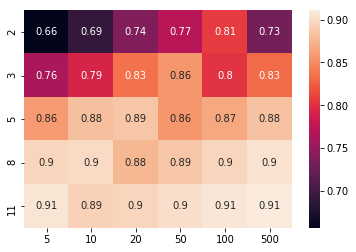

In [261]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [262]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [263]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

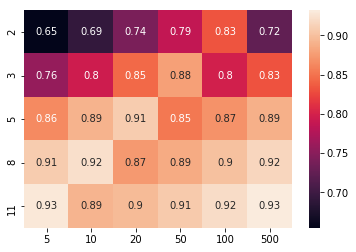

In [264]:
sns.heatmap(auc_score_tr_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [265]:
best_max_depth=11
best_max_estimators=500

In [266]:
rfc = RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0,class_weight='balanced')
rfc.fit(final_counts_x_train, y_tr)
prediction = rfc.predict_proba(final_counts_x_test)[:,1]

In [267]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9083176436345184


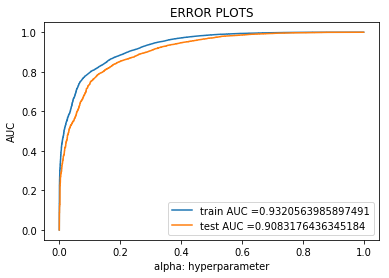

Train confusion matrix
[[ 6020  2005]
 [ 3875 40763]]
Test confusion matrix
[[ 2086   828]
 [ 1495 13146]]


In [268]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


rfc= RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0,class_weight='balanced')
rfc=rfc.fit(final_counts_x_train, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,rfc.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,rfc.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rfc.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,rfc.predict(final_counts_x_test))
print(confusion_matrix(y_test,rfc.predict(final_counts_x_test)))


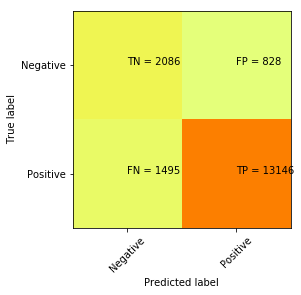

In [269]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [270]:
feature_names=count_vect.get_feature_names()
top_features=rfc.feature_importances_
zipped_data=sorted(zip(top_features,feature_names),reverse=True)
top_20=zipped_data[:20]

In [271]:
print(top_20)

[(0.047716150192281356, 'delicious'), (0.03607129084908625, 'bad'), (0.03411133776829057, 'disappointed'), (0.027157701079891145, 'excellent'), (0.02596248656254726, 'not buy'), (0.02454910234337688, 'worst'), (0.02428843139337763, 'perfect'), (0.0241599462865706, 'money'), (0.023324619366579664, 'loves'), (0.0222888166047898, 'horrible'), (0.02073082688514028, 'not good'), (0.02022841899614904, 'waste'), (0.019149994198517456, 'awful'), (0.018625682480390832, 'would not'), (0.018124384805923384, 'favorite'), (0.01776009679649934, 'terrible'), (0.017574622148155715, 'easy'), (0.015710953399607156, 'wonderful'), (0.01567405751929429, 'thought'), (0.013783385888112846, 'yummy')]


In [272]:
top_20_list=[]
for i in range(20):
    top_20_list.append(top_20[i][1])

In [273]:
print(top_20_list)

['delicious', 'bad', 'disappointed', 'excellent', 'not buy', 'worst', 'perfect', 'money', 'loves', 'horrible', 'not good', 'waste', 'awful', 'would not', 'favorite', 'terrible', 'easy', 'wonderful', 'thought', 'yummy']


In [274]:
top_20_list_join=' '.join(top_20_list)

In [275]:
print(top_20_list_join)

delicious bad disappointed excellent not buy worst perfect money loves horrible not good waste awful would not favorite terrible easy wonderful thought yummy


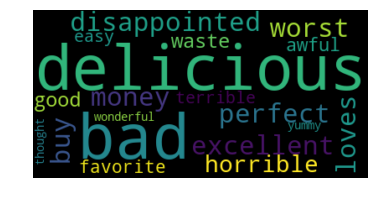

In [276]:
#Reference:https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
#top_20=pd.Series(top_20)
#text = top_20

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(top_20_list_join)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [227]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=300,max_df=7000)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_tf_idf_tr))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_tr.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'absolutely love', 'acid', 'across', 'actual', 'actually', 'add', 'added', 'addicted']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (52663, 1206)
the number of unique words including both unigrams and bigrams  1206


In [228]:
np.hstack((final_tf_idf_tr,length_of_summary[:52663]))
np.hstack((final_tf_idf_cv,length_of_summary[52663:70218]))
np.hstack((final_tf_idf_test,length_of_summary[70218:]))

array([<17555x1206 sparse matrix of type '<class 'numpy.float64'>'
	with 397267 stored elements in Compressed Sparse Row format>,
       3, 6, ..., 13, 42, 9], dtype=object)

In [229]:
from sklearn.preprocessing import normalize
final_tf_idf_tr=normalize(final_tf_idf_tr)
final_tf_idf_cv=normalize(final_tf_idf_cv)
final_tf_idf_test=normalize(final_tf_idf_test)

In [233]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        rfc = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 0,class_weight='balanced')
        rfc.fit(final_tf_idf_tr, y_tr)
    
    
        pred_tr = rfc.predict_proba(final_tf_idf_tr)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = rfc.predict_proba(final_tf_idf_cv)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.6583018924546219
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.6696095312979969
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.6998447518068158
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.7014017446295097
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.7737558698224374
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.7612621998706716
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.8178183571294675
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.7955146986344299
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.8463338404240188
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8139892626182079
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.71557613276

In [234]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [235]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

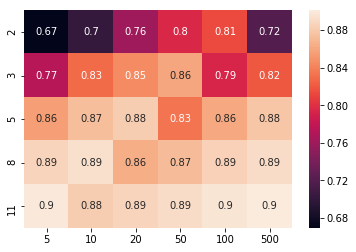

In [236]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [237]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [238]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

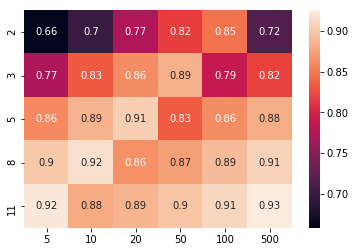

In [240]:
sns.heatmap(auc_score_tr_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [241]:
best_max_depth=11
best_max_estimators=500

In [244]:
rfc = RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0,class_weight='balanced')
rfc.fit(final_tf_idf_tr, y_tr)
prediction = rfc.predict_proba(final_tf_idf_test)[:,1]

In [245]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.8989942521394095


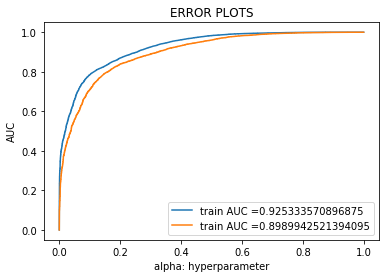

Train confusion matrix
[[ 5931  2094]
 [ 4271 40367]]
Test confusion matrix
[[ 2048   866]
 [ 1642 12999]]


In [247]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


rfc= RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0,class_weight='balanced')
rfc=rfc.fit(final_tf_idf_tr, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,rfc.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,rfc.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rfc.predict(final_tf_idf_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,rfc.predict(final_tf_idf_test))
print(confusion_matrix(y_test,rfc.predict(final_tf_idf_test)))


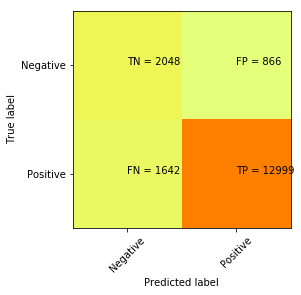

In [248]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [85]:
# Please write all the code with proper documentation
feature_names=count_vect.get_feature_names()
top_features=rfc.feature_importances_
zipped_data=sorted(zip(top_features,feature_names),reverse=True)
top_20=zipped_data[:20]

In [86]:
print(top_20)

[(0.02808446006304624, 'inhibit'), (0.01934319859625233, 'anythiing'), (0.019152119541325497, 'riddled'), (0.017158165593557616, 'equitable'), (0.015946447992671, 'coffrr'), (0.015531679269840134, 'insalata'), (0.015349514264862243, 'refute'), (0.013122690015973002, 'poo'), (0.013017221137249664, 'reg'), (0.013016186520410143, 'anough'), (0.012373905584563805, 'hounded'), (0.012047609702095724, 'interlerance'), (0.011470877164622209, 'coins'), (0.011239038807823551, 'fennel'), (0.01076771542515312, 'roamed'), (0.010547831575820217, 'misdirection'), (0.01002768143290249, 'roxy'), (0.009995819638592581, 'ciric'), (0.009955593723074701, 'molecules'), (0.009719184066672727, 'cointreau')]


In [87]:
top_20_list=[]
for i in range(20):
    top_20_list.append(top_20[i][1])

In [88]:
print(top_20_list)

['inhibit', 'anythiing', 'riddled', 'equitable', 'coffrr', 'insalata', 'refute', 'poo', 'reg', 'anough', 'hounded', 'interlerance', 'coins', 'fennel', 'roamed', 'misdirection', 'roxy', 'ciric', 'molecules', 'cointreau']


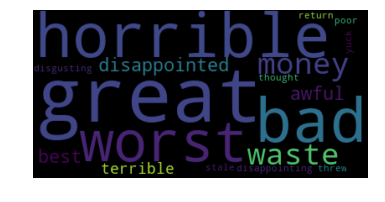

In [89]:
#Reference:https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
#top_20=pd.Series(top_20)
#text = top_20

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(top_20_list_join)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [90]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]

for sentance in x_tr:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [91]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [92]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12584
sample words  ['bought', 'apartment', 'infested', 'fruit', 'fly', 'hour', 'trap', 'attracted', 'many', 'within', 'day', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decal', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumb', 'great', 'received', 'shipment', 'could']


In [93]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|███████████████████████████████████████████████████████████████████████████| 52663/52663 [02:31<00:00, 347.64it/s]


52663
50


In [94]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:51<00:00, 342.37it/s]


17555
50


In [95]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:53<00:00, 328.30it/s]


17555
50


In [96]:
len(length_of_summary[:52663])

52663

In [98]:
from sklearn.preprocessing import normalize
sent_vectors_tr=normalize(sent_vectors_tr)
sent_vectors_cv=normalize(sent_vectors_cv)
sent_vectors_test=normalize(sent_vectors_test)

In [99]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        rfc = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 0)
        rfc.fit(sent_vectors_tr, y_tr)
    
    
        pred_tr = rfc.predict_proba(sent_vectors_tr)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = rfc.predict_proba(sent_vectors_cv)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.7945778648006623
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.784924387879976
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.8344209821368128
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.8247119146784977
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.871946016686117
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.8585639845538452
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.9180926495020726
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.8781987923731928
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.9626289016008183
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8747243320470732
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.8102338311978

In [100]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [101]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

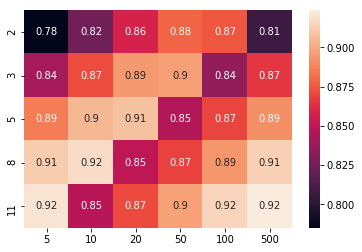

In [102]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [103]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [104]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

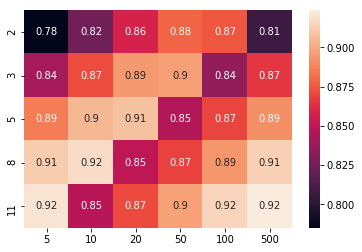

In [105]:
sns.heatmap(auc_score_tr_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [106]:
best_max_depth=11
best_max_estimators=500

In [107]:
rfc = RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
rfc.fit(sent_vectors_tr, y_tr)
prediction = rfc.predict_proba(sent_vectors_test)[:,1]

In [108]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9187020616083763


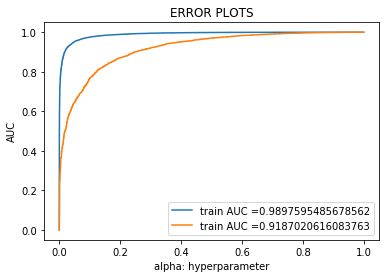

Train confusion matrix
[[ 4793  3232]
 [  111 44527]]
Test confusion matrix
[[ 1015  1899]
 [  187 14454]]


In [109]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


rfc= RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
rfc=rfc.fit(sent_vectors_tr, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,rfc.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,rfc.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rfc.predict(sent_vectors_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,rfc.predict(sent_vectors_test))
print(confusion_matrix(y_test,rfc.predict(sent_vectors_test)))

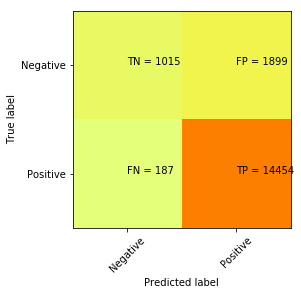

In [110]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [111]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [112]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 52663/52663 [29:05<00:00, 23.84it/s]


In [113]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [09:58<00:00, 18.63it/s]


In [114]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [10:17<00:00, 28.45it/s]


In [115]:
from sklearn.preprocessing import normalize
tfidf_sent_vectors_train=normalize(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv=normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test=normalize(tfidf_sent_vectors_test)

In [116]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        rfc = RandomForestClassifier(n_estimators = i, max_depth = j, random_state = 0)
        rfc.fit(tfidf_sent_vectors_train, y_tr)
    
    
        pred_tr = rfc.predict_proba(tfidf_sent_vectors_train)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = rfc.predict_proba(tfidf_sent_vectors_cv)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.7632704236601004
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.7529212172055506
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.7913412792894421
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.7845231939506339
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.8370942880205304
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.8180183883945145
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.8924798046563291
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.8396188665213908
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.9436779121319179
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8398279920761585
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.78330395194

In [117]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [118]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

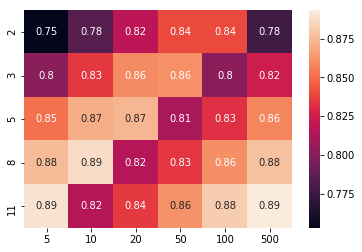

In [119]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [120]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [121]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

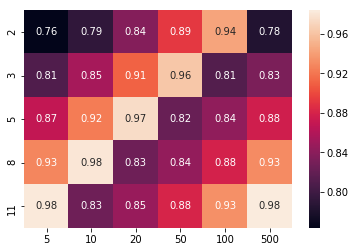

In [122]:
sns.heatmap(auc_score_tr_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [123]:
best_max_depth=8
best_max_estimators=500

In [124]:
rfc = RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
rfc.fit(tfidf_sent_vectors_train, y_tr)
prediction = rfc.predict_proba(tfidf_sent_vectors_test)[:,1]

In [125]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.8771683509097181


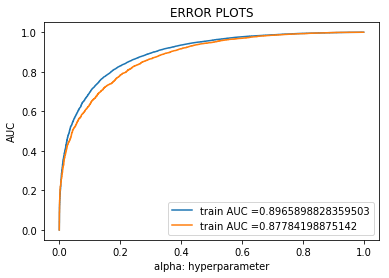

Train confusion matrix
[[ 1635  6390]
 [  272 44366]]
Test confusion matrix
[[  634  2280]
 [  115 14526]]


In [126]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


rfc= RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
rfc=rfc.fit(sent_vectors_tr, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,rfc.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,rfc.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rfc.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,rfc.predict(tfidf_sent_vectors_test))
print(confusion_matrix(y_test,rfc.predict(tfidf_sent_vectors_test)))

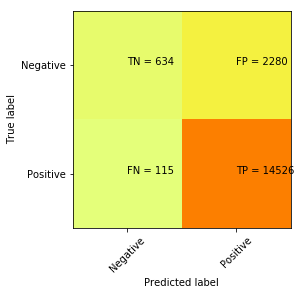

In [127]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [144]:
%%time
# Please write all the code with proper documentation

#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_tr)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_test))
print("the shape of out text BOW vectorizer ",final_counts_x_test.get_shape())
print("the number of unique words ", final_counts_x_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaagh', 'aaaaaawwwwwwwwww']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 39991)
the number of unique words  39991
Wall time: 17.2 s


In [145]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        xgb = XGBClassifier(n_estimators = i, max_depth = j, random_state = 0)
        xgb.fit(final_counts_x_train, y_tr)
    
    
        pred_tr = xgb.predict_proba(final_counts_x_train)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = xgb.predict_proba(final_counts_x_crossval)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.7541453163063644
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.7646414395389446
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.7857674774953209
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.8016504993045024
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.8291099281321433
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.8382419005978654
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.8575699776073331
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.8585282646850253
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.8799650452187266
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8654969470987773
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.77861992052

In [146]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [147]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

In [148]:
len(auc_score_cv)

30

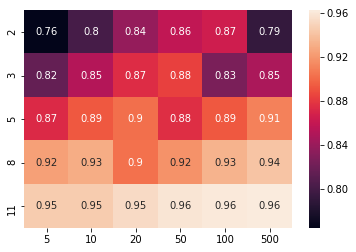

In [149]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [151]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [152]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

In [153]:
len(auc_score_tr)

30

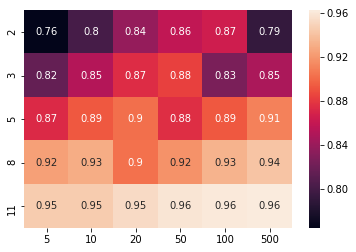

In [154]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [158]:
best_max_depth=11
best_max_estimators=500

In [159]:
xgb = XGBClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
xgb.fit(final_counts_x_train, y_tr)
prediction = xgb.predict_proba(final_counts_x_test)[:,1]

In [160]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9619324185140806


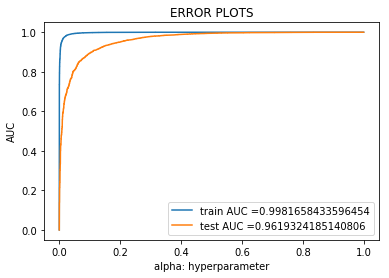

Train confusion matrix
[[ 7364   661]
 [  130 44508]]
Test confusion matrix
[[ 1977   937]
 [  274 14367]]


In [161]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


xgb= XGBClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
xgb=xgb.fit(final_counts_x_train, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,xgb.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, xgb.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,xgb.predict(final_counts_x_test))
print(confusion_matrix(y_test,xgb.predict(final_counts_x_test)))


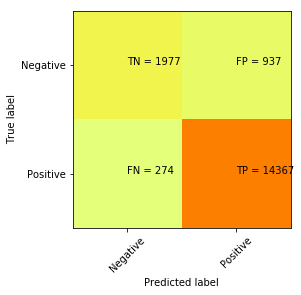

In [162]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [163]:
feature_names=count_vect.get_feature_names()
top_features=xgb.feature_importances_
zipped_data=sorted(zip(top_features,feature_names),reverse=True)
top_20=zipped_data[:20]

In [164]:
print(top_20)

[(0.061700467, 'not'), (0.032264147, 'like'), (0.025288843, 'taste'), (0.022595676, 'product'), (0.022568744, 'good'), (0.021841587, 'would'), (0.02138375, 'one'), (0.014085266, 'flavor'), (0.013061862, 'no'), (0.012442433, 'food'), (0.011499825, 'great'), (0.011203577, 'love'), (0.010988123, 'get'), (0.009264496, 'amazon'), (0.0077024586, 'much'), (0.007433142, 'dog'), (0.0072446205, 'really'), (0.0072446205, 'make'), (0.007029167, 'time'), (0.0070022354, 'best')]


In [165]:
top_20_list=[]
for i in range(20):
    top_20_list.append(top_20[i][1])

In [166]:
print(top_20_list)

['not', 'like', 'taste', 'product', 'good', 'would', 'one', 'flavor', 'no', 'food', 'great', 'love', 'get', 'amazon', 'much', 'dog', 'really', 'make', 'time', 'best']


In [167]:
top_20_list_join=' '.join(top_20_list)

In [168]:
print(top_20_list_join)

not like taste product good would one flavor no food great love get amazon much dog really make time best


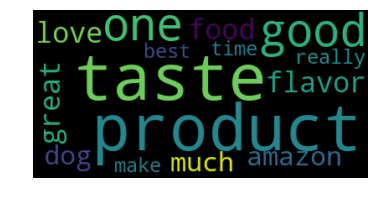

In [169]:
#Reference:https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
#top_20=pd.Series(top_20)
#text = top_20

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(top_20_list_join)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [170]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_tf_idf_tr))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_tr.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (52663, 33860)
the number of unique words including both unigrams and bigrams  33860


In [171]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        xgb = XGBClassifier(n_estimators = i, max_depth = j, random_state = 0)
        xgb.fit(final_tf_idf_tr, y_tr)
    
    
        pred_tr = xgb.predict_proba(final_tf_idf_tr)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = xgb.predict_proba(final_tf_idf_cv)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.7206941447565944
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.7283757625033657
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.779291057072617
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.7902973457648391
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.8286770725639374
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.8318683230513988
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.870122098169016
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.8612712381288814
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.8988686489962382
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8771227892418263
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.7985539275520

In [172]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [173]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

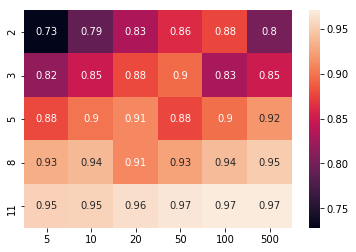

In [174]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [181]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [182]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

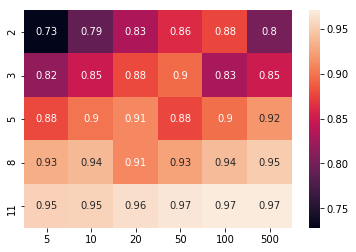

In [183]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [184]:
best_max_depth=11
best_max_estimators=500

In [185]:
xgb = XGBClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
xgb.fit(final_tf_idf_tr, y_tr)
prediction = xgb.predict_proba(final_tf_idf_test)[:,1]

In [186]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9698960530400966


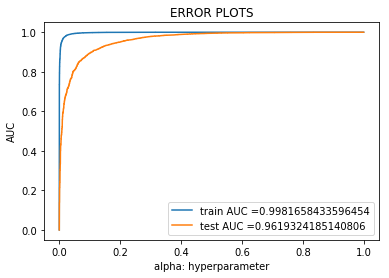

Train confusion matrix
[[ 7364   661]
 [  130 44508]]
Test confusion matrix
[[ 1977   937]
 [  274 14367]]


In [187]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


xgb= XGBClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
xgb=xgb.fit(final_counts_x_train, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,xgb.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, xgb.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,xgb.predict(final_counts_x_test))
print(confusion_matrix(y_test,xgb.predict(final_counts_x_test)))

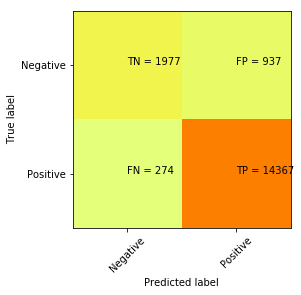

In [188]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [189]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]

for sentance in x_tr:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [190]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [191]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12584
sample words  ['bought', 'apartment', 'infested', 'fruit', 'fly', 'hour', 'trap', 'attracted', 'many', 'within', 'day', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decal', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumb', 'great', 'received', 'shipment', 'could']


In [192]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|███████████████████████████████████████████████████████████████████████████| 52663/52663 [02:41<00:00, 325.16it/s]


52663
50


In [193]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:56<00:00, 312.58it/s]


17555
50


In [194]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:56<00:00, 310.55it/s]


17555
50


In [195]:
from sklearn.preprocessing import normalize
sent_vectors_tr=normalize(sent_vectors_tr)
sent_vectors_cv=normalize(sent_vectors_cv)
sent_vectors_test=normalize(sent_vectors_test)

In [196]:
%%time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        xgb = XGBClassifier(n_estimators = i, max_depth = j, random_state = 0)
        xgb.fit(sent_vectors_tr, y_tr)
    
    
        pred_tr = xgb.predict_proba(sent_vectors_tr)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = xgb.predict_proba(sent_vectors_cv)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.7997374936823033
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.7953914947188686
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.8275831217663896
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.8212611059698923
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.8707440973066967
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.8555285176441929
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.9260205329156012
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.8766047811049803
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.968297518047222
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8792744614726032
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.825904714408

In [197]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [198]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

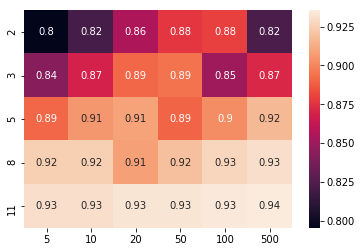

In [199]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [200]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [201]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

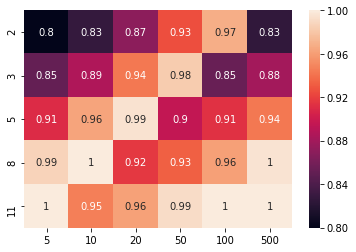

In [202]:
sns.heatmap(auc_score_tr_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [203]:
xgb = XGBClassifier(n_estimators = 500, max_depth =2, random_state = 0)
xgb.fit(sent_vectors_tr, y_tr)
prediction = xgb.predict_proba(sent_vectors_test)[:,1]

In [204]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.932037571177901


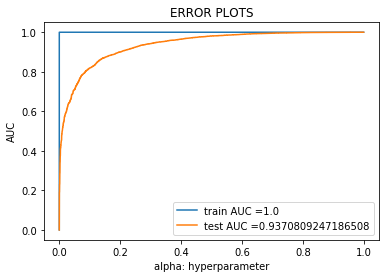

Train confusion matrix
[[ 8025     0]
 [    0 44638]]
Test confusion matrix
[[ 1667  1247]
 [  428 14213]]


In [205]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


xgb= XGBClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
xgb=xgb.fit(sent_vectors_tr, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,xgb.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, xgb.predict(sent_vectors_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,xgb.predict(sent_vectors_test))
print(confusion_matrix(y_test,xgb.predict(sent_vectors_test)))

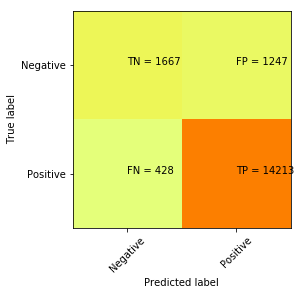

In [206]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [128]:
%%time
# Please write all the code with proper documentation
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_score_tr = []
auc_score_cv = []
maximum_depth = [2, 3, 5, 8, 11]
n_estimators = [5, 10, 20, 50, 100,500]

for i in n_estimators:
    for j in maximum_depth:

        rfc = XGBClassifier(n_estimators = i, max_depth = j, random_state = 0)
        rfc.fit(tfidf_sent_vectors_train, y_tr)
    
    
        pred_tr = rfc.predict_proba(tfidf_sent_vectors_train)[:,1]
        auc_tr = roc_auc_score(y_tr, pred_tr)
        print("AUC score on train data for depth value", j,"and n_estimators",i,"is", auc_tr)
        auc_score_tr.append(auc_tr)
    
        pred_cv = rfc.predict_proba(tfidf_sent_vectors_cv)[:,1]
        auc_cv = roc_auc_score(y_cv, pred_cv)
        print("AUC score on crossval dat afor depth value",j,"and n_estimators",i,"is", auc_cv)
        print("**************")
        
        auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for depth value 2 and n_estimators 5 is 0.757555016129057
AUC score on crossval dat afor depth value 2 and n_estimators 5 is 0.7434384378889989
**************
AUC score on train data for depth value 3 and n_estimators 5 is 0.803404285551377
AUC score on crossval dat afor depth value 3 and n_estimators 5 is 0.790907697574622
**************
AUC score on train data for depth value 5 and n_estimators 5 is 0.8557222245718028
AUC score on crossval dat afor depth value 5 and n_estimators 5 is 0.8324440109643512
**************
AUC score on train data for depth value 8 and n_estimators 5 is 0.9119900413140026
AUC score on crossval dat afor depth value 8 and n_estimators 5 is 0.8538470654301364
**************
AUC score on train data for depth value 11 and n_estimators 5 is 0.9633036029958688
AUC score on crossval dat afor depth value 11 and n_estimators 5 is 0.8556277359102843
**************
AUC score on train data for depth value 2 and n_estimators 10 is 0.78519752598927

In [129]:
auc_score_cv_pd=pd.Series(auc_score_cv)

In [130]:
auc_score_cv_pd=auc_score_cv_pd.values.reshape(5,6)

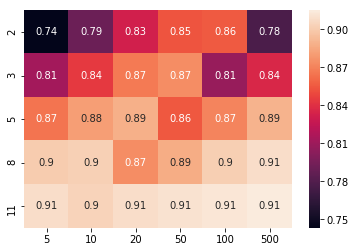

In [131]:
sns.heatmap(auc_score_cv_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [138]:
auc_score_tr_pd=pd.Series(auc_score_tr)

In [139]:
auc_score_tr_pd=auc_score_tr_pd.values.reshape(5,6)

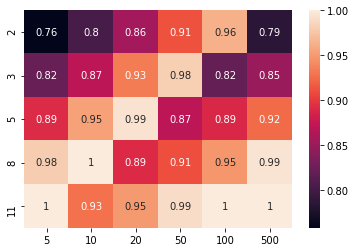

In [140]:
sns.heatmap(auc_score_tr_pd,annot=True,xticklabels= n_estimators ,yticklabels= maximum_depth)

In [135]:
best_max_depth=8
best_max_estimators=500

In [136]:
rfc = XGBClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
rfc.fit(tfidf_sent_vectors_train, y_tr)
prediction = rfc.predict_proba(tfidf_sent_vectors_test)[:,1]

In [137]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("roc auc score")
print(roc_auc_score(y_test,prediction))

roc auc score
0.9119033822385656


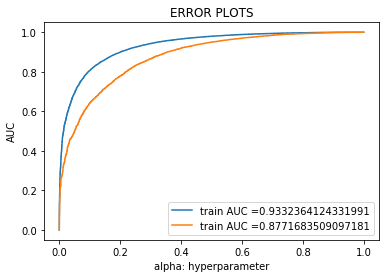

Train confusion matrix
[[ 1790  6235]
 [  142 44496]]
Test confusion matrix
[[  553  2361]
 [   91 14550]]


In [141]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


rfc= RandomForestClassifier(n_estimators = best_max_estimators, max_depth = best_max_depth, random_state = 0)
rfc=rfc.fit(tfidf_sent_vectors_train, y_tr)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr,rfc.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,rfc.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, rfc.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,rfc.predict(tfidf_sent_vectors_test))
print(confusion_matrix(y_test,rfc.predict(tfidf_sent_vectors_test)))

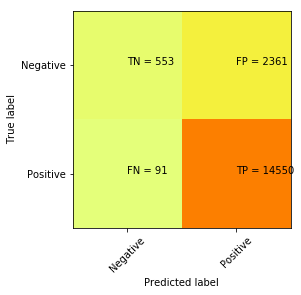

In [142]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


# [6] Conclusions

In [90]:
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
# reference from "http://zetcode.com/python/prettytable/"
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["algorithm", "n_estimator", "maximum_depth", "AUC" ]
t.add_row(["random_forest",500,11,0.9083])
t.add_row(["random_forest", 500,11,0.89])
t.add_row(["random_forest", 500,11,0.9187])
t.add_row(["random_forest", 500,8,0.8771])
t.add_row(["xgboost", 500,11,0.9619])
t.add_row(["xgboost", 500,11,0.9698])
t.add_row(["xgboost", 500,2,0.9320])
t.add_row(["xgboost", 500, 8,0.9190])
print(t)

+---------------+-------------+---------------+--------+
|   algorithm   | n_estimator | maximum_depth |  AUC   |
+---------------+-------------+---------------+--------+
| random_forest |     500     |       11      | 0.9186 |
| random_forest |     500     |       11      | 0.9347 |
| random_forest |     500     |       11      | 0.9187 |
| random_forest |     500     |       8       | 0.8771 |
|    xgboost    |     500     |       11      | 0.9619 |
|    xgboost    |     500     |       11      | 0.9698 |
|    xgboost    |     500     |       2       | 0.932  |
|    xgboost    |     500     |       8       | 0.919  |
+---------------+-------------+---------------+--------+


1.Balancing  class_weight is crucial as majority of reviews belong to positive class


2.Played with min_df and max_df to get unbiased confusion matrix and better AUC.